### Naive Bayes From Scratch
The Naive Bayes algorithm uses the probability of each classified attribute (classified here means that this particular attribute belongs to that particular class) in which there is a large number of attributes that belong to number of classes. Naive Bayes uses these probabilities of finding the attribute corresponding class to make predictions. Because we split our data into ratios, namely train set and test set, using this technique in this way is considered a 'supervised learning', i.e. a probabilistic approach for a predictive modelling.
The article in wikipedia is a nice simplified [introduction](https://en.wikipedia.org/wiki/Statistics), though you might find better sources out there.

In this tutorial, we will step by step build our Naive Bayes model from scratch where we will not use any of those popular libraries, such as 'scikit-learn'. But we will still at the end of the tutorial compare our model prediction accuracy and scoring to that one used by scikit-learn.

### The normal distribution apporach

We will use the Gaussian probability density function (or the standard normal distribution) with a domain that been stretched by a factor $\sigma$ (the standard deviation) and then translated by $\mu$ (the mean value). Or mathematically we can write its relationship in the following format:

$\begin{equation}
f(x | \mu, \sigma^2) = \frac{1}{\sqrt{\pi\sigma^2}} e^{\frac{(x-\mu)^2}{2\sigma^2}}
\end{equation}$

For sure one can use or come up with a different estimator but I find the use of the standard deviation as it less affected by noise is very convenient, we can measure the deviation from the mean for each attribute without being driven by the noise when averaging.

### The process

We will follow the steps below to execute this tutorial:

* Prepare the Data: Load the data from a file and split it into training and test datasets. One can also load directly from the online database but this should be covered in a different tutorial.
* Split the Data: We split our data, using a given ratio, to create our training set and test set.
* Classify our Data:  We divide the training data into classes (using the given ones) such that we can associate probabilities with each class.
* Build the Model: We use the Gaussian distribution function (equation above) to create our probability calculator. This require to calculate the mean $\mu$ and the standard deviation $\sigma$ of each set of attributes and then we associate that with the given classes. 
* Predict: After training our model we use the outcome (the summary/result of the Gaussian model evaluation for each class), we generate predictions given the test the model outcome.
* Measure Accuracy: We check how accurate is our model
* Compare Accuracy: We compare the prediction made by our model to that made by 'scikit-learn' model.

In [86]:
import os, csv, random, math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from pandas import Series
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score

In [115]:
def load_data(_file, _folder):
    _dir = data_dir = os.path.join(
    os.path.dirname(os.path.realpath("__file__")), _folder)
    file_path = _dir+'/'+_file
    data = csv.reader(open(file_path, "rb"))
    dataset = list(data)
    for line in range(len(dataset)):
        dataset[line] = [float(x) for x in dataset[line]] 
    dataset = dataset[:-1]
    
    return _file, dataset 
    
_file, dataset = load_data('pima-indians-diabetes.csv', 'data')
print("Loaded data file '{0}' with {1} rows").format(_file, len(dataset))

Loaded data file 'pima-indians-diabetes.csv' with 768 rows


In [160]:
# It is important to randomly shuffle the data when producing the training and test sets. 
def split_data(dataset, split_ratio):
    train_size = int(len(dataset)*split_ratio)
    train_set = []
    data = list(dataset)
    while len(train_set) < train_size:
        index = random.randrange(len(data))
        train_set.append(data.pop(index))
    
    return [train_set, data]

# and let's test it to see if it can shuffle randomly
split_ratio = 0.68
train_set, test_set = split_data(dataset, split_ratio)
print 'Training set size is {0} while test set size is {1}. Split ratio {2}%'.format(len(train_set), 
                                                                                     len(test_set), 
                                                                                    split_ratio*100)

Training set size is 522 while test set size is 246. Split ratio 68.0%


In [130]:
"""Classifications: a simple scenario that we take each vector from our dataset (i.e. row by row) and 
and test it against our argument of classification: the vectors that contain large number of elements that are a like
will be put in same class, and so on"""

def classify_data(dataset):
    _class = {}
    for x in range(len(dataset)):
        _row = dataset[x]
        if (_row[-1] not in _class): 
            #[-1] means takes the last element and classify accordingly
            # the reason of that because our 'class:0,1' is at the end of the row
            _class[_row[-1]] = []
        _class[_row[-1]].append(_row)
    
    return _class

# Let's test it

data = [[6.0, 148.0, 72.0, 35.0, 0.0, 33.6, 0.627, 50.0, 1.0], 
        [1.0, 85.0, 66.0, 29.0, 0.0, 26.6, 0.351, 31.0, 0.0], 
        [8.0, 183.0, 64.0, 0.0, 0.0, 23.3, 0.672, 32.0, 1.0], 
        [1.0, 89.0, 66.0, 23.0, 94.0, 28.1, 0.167, 21.0, 0.0], 
        [0.0, 137.0, 40.0, 35.0, 168.0, 43.1, 2.288, 33.0, 1.0], 
        [5.0, 116.0, 74.0, 0.0, 0.0, 25.6, 0.201, 30.0, 0.0], 
        [3.0, 78.0, 50.0, 32.0, 88.0, 31.0, 0.248, 26.0, 1.0]]
class_data = classify_data(data)
print('Classified instances (dummy data): {0}').format(class_data) 
print '-'*30
class_data = classify_data(train_set[:10]) # print small portion
print('Classified instances (real data): {0}').format(class_data) 

Classified instances (dummy data): {0.0: [[1.0, 85.0, 66.0, 29.0, 0.0, 26.6, 0.351, 31.0, 0.0], [1.0, 89.0, 66.0, 23.0, 94.0, 28.1, 0.167, 21.0, 0.0], [5.0, 116.0, 74.0, 0.0, 0.0, 25.6, 0.201, 30.0, 0.0]], 1.0: [[6.0, 148.0, 72.0, 35.0, 0.0, 33.6, 0.627, 50.0, 1.0], [8.0, 183.0, 64.0, 0.0, 0.0, 23.3, 0.672, 32.0, 1.0], [0.0, 137.0, 40.0, 35.0, 168.0, 43.1, 2.288, 33.0, 1.0], [3.0, 78.0, 50.0, 32.0, 88.0, 31.0, 0.248, 26.0, 1.0]]}
------------------------------
Classified instances (real data): {0.0: [[2.0, 139.0, 75.0, 0.0, 0.0, 25.6, 0.167, 29.0, 0.0], [3.0, 78.0, 70.0, 0.0, 0.0, 32.5, 0.27, 39.0, 0.0], [10.0, 162.0, 84.0, 0.0, 0.0, 27.7, 0.182, 54.0, 0.0], [5.0, 147.0, 75.0, 0.0, 0.0, 29.9, 0.434, 28.0, 0.0], [0.0, 93.0, 60.0, 0.0, 0.0, 35.3, 0.263, 25.0, 0.0]], 1.0: [[7.0, 196.0, 90.0, 0.0, 0.0, 39.8, 0.451, 41.0, 1.0], [6.0, 115.0, 60.0, 39.0, 0.0, 33.7, 0.245, 40.0, 1.0], [0.0, 145.0, 0.0, 0.0, 0.0, 44.2, 0.63, 31.0, 1.0], [12.0, 140.0, 82.0, 43.0, 325.0, 39.2, 0.528, 58.0, 1.0], 

In [131]:
"""Here are estimation tools, the mean and the standard deviation"""
def mean(enteries):
    enteries = enteries#[:-1]
    mean = sum(enteries)/float(len(enteries))
    #print mean
    
    return mean

def stdev(enteries):
    enteries = enteries#[:-1]
    _mean = mean(enteries)
    variance = sum([pow(x-_mean,2) for x in enteries])/float(len(enteries)-1)
    _stdev = math.sqrt(variance)
    
    return _stdev

# Do the test on real data
for i in train_set[:10]: 
    print('Attributes: {0}, summary: mean={1}, stdev={2}').format(i[:-1], mean(i), stdev(i))

Attributes: [7.0, 196.0, 90.0, 0.0, 0.0, 39.8, 0.451, 41.0], summary: mean=41.6945555556, stdev=65.3694497971
Attributes: [2.0, 139.0, 75.0, 0.0, 0.0, 25.6, 0.167, 29.0], summary: mean=30.0852222222, stdev=47.8282115016
Attributes: [3.0, 78.0, 70.0, 0.0, 0.0, 32.5, 0.27, 39.0], summary: mean=24.7522222222, stdev=31.7337957774
Attributes: [10.0, 162.0, 84.0, 0.0, 0.0, 27.7, 0.182, 54.0], summary: mean=37.5424444444, stdev=55.2250021619
Attributes: [6.0, 115.0, 60.0, 39.0, 0.0, 33.7, 0.245, 40.0], summary: mean=32.7716666667, stdev=37.8366733474
Attributes: [0.0, 145.0, 0.0, 0.0, 0.0, 44.2, 0.63, 31.0], summary: mean=24.6477777778, stdev=48.0539024892
Attributes: [5.0, 147.0, 75.0, 0.0, 0.0, 29.9, 0.434, 28.0], summary: mean=31.7037777778, stdev=49.8636047478
Attributes: [12.0, 140.0, 82.0, 43.0, 325.0, 39.2, 0.528, 58.0], summary: mean=77.8586666667, stdev=102.643905693
Attributes: [0.0, 123.0, 72.0, 0.0, 0.0, 36.3, 0.258, 52.0], summary: mean=31.6175555556, stdev=43.7874528122
Attribut

In [132]:
""" Let's put the training data, after measuring the mean and standard deviation, into summary class, such that we 
will have [(mean_1, stdev_1), ... (mean_n, stdev_n)]"""
def summary_data(dataset):
    summary = [(mean(attribute), stdev(attribute)) for attribute in zip(*dataset)]
    del summary[-1]
    
    return summary

# Test it:
summary = summary_data(train_set)
print('Attribute summaries: {0}').format(summary)

Attribute summaries: [(3.7296786389413987, 3.285742860683327), (119.24952741020795, 31.589011514298416), (68.55576559546314, 19.707261242299072), (20.95274102079395, 15.975704715186053), (78.69565217391305, 112.0404925448694), (32.37088846880907, 7.636117290698853), (0.4739546313799622, 0.3260060271773697), (32.56899810964083, 11.495365631500826)]


In [133]:
""" separat the training dataset into instances grouped by class, 
then calculate the summaries (which decrib the mean and stdev, from above fucntion) for each attribute
this should give {class: (mean, stdev)} such that: 
{0: [(m1, st1), (m2, st2), ...], 1: [(m1, st1), (m2, st2), ...]}
"""
def sort_data(dataset):
    separated = classify_data(dataset)
    classes = {}
    for classValue, instances in separated.iteritems():
        classes[classValue] = summary_data(instances)
    
    return classes

sorted_data = sort_data(train_set)
print('Data sorted by class value: {0}').format(sorted_data)

Data sorted by class value: {0.0: [(3.1729106628242074, 2.922716172887118), (108.71469740634005, 25.20303421516836), (67.54755043227665, 18.547234296564014), (19.80979827089337, 14.796055431011643), (69.28530259365995, 98.47869924672679), (30.52247838616713, 7.398200192897232), (0.4184351585014407, 0.2815707967066099), (30.746397694524497, 11.60646657969856)], 1.0: [(4.791208791208791, 3.665627963256114), (139.33516483516485, 32.8364905279732), (70.47802197802197, 21.672271676077802), (23.13186813186813, 17.853429521021233), (96.63736263736264, 132.61459270582085), (35.89505494505495, 6.814076083365414), (0.5798076923076926, 0.37589898335371674), (36.043956043956044, 10.462151821080543)]}


### Predict

All that being given, we are now ready to carry our predictions using the training set. The process is now simple, we just need to allow for this scenario: calculate the probability that a given set of attributes will belong to a specific class, then we mark the class with the highest probability scor as our prediction.
* In steps:
    *  Calculate Gaussian Probability Density Function per class:  $\begin{equation}
f(x | \mu, \sigma^2) = \frac{1}{\sqrt{\pi\sigma^2}} e^{\frac{(x-\mu)^2}{2\sigma^2}}
\end{equation}$
    * Calculate all the probabilities for all classes
    * Predict
    * Measure the model accuracy

In [174]:
def gaussian_estimator(x, mean, stdev):
    base = math.exp(-(math.pow(x-mean,2)/(2*math.pow(stdev,2))))
    estimator = (1 / (math.sqrt(2*math.pi) * stdev)) * base
    
    return estimator


x = 71.5
mean = 73
stdev = 6.2
probability = gaussian_estimator(x, mean, stdev)
print(r'Probability of a class: {}%').format(probability*100)

Probability of a class: 6.24896575937%


In [170]:
def class_probability(train, test):
    probabilities = {}
    for target, vector in train.iteritems():
        probabilities[target] = 1 # we need to have initial value here.
        for i in range(len(vector)):
            mean, stdev = vector[i]
            x = test[i]
            probabilities[target] *= gaussian_estimator(x, mean, stdev)
            
    return probabilities

# Let's put our probability calculator for a test 
for i in range(len(test_set[:10])):
    probabilities = class_probability(sorted_data, test_set[i])
    print("Attribute's probability: {0}" ).format(probabilities)

Attribute's probability: {0.0: 1.533497250704814e-61, 1.0: 1.2553324910582577e-07}
Attribute's probability: {0.0: 2.833001729644838e-11, 1.0: 6.175116937276354e-08}
Attribute's probability: {0.0: 0.0, 1.0: 0.0}
Attribute's probability: {0.0: 1.4525505077438077e-10, 1.0: 2.596587773275098e-09}
Attribute's probability: {0.0: 2.1133493035681783e+114, 1.0: 5.407311340332201e+67}
Attribute's probability: {0.0: 1.880145430461084e-11, 1.0: 7.374573905358729e-11}
Attribute's probability: {0.0: 1.3394399602778206e-11, 1.0: 7.835960809781692e-12}
Attribute's probability: {0.0: 8.504505891331194e-27, 1.0: 3.8029793078450343e-13}
Attribute's probability: {0.0: 4.877069692184557e-14, 1.0: 2.976436785203724e-11}
Attribute's probability: {0.0: 2.4949984065965333e-11, 1.0: 2.7747234981821294e-05}


In [180]:
def predict(train_set, test_set):
    predictions = []
    for i in range(len(test_set)):
        probabilities = class_probability(train_set, test_set[i])
        _class, _prob = None, -1
        for Class, probability in probabilities.iteritems():
            if _class is None or probability > _prob:
                _prob = probability
                _class = Class
        predictions.append(_class)
        
    print predictions
    return predictions


train = {'A':[(1, 0.5)], 'B':[(20, 5.0)]}
test = [[1.1, '?'], [19.1, '?']]
predictions = predict(train, test)
print('Predictions: {0}').format(predictions)
print'-'*30

#train_set = sort_data(train_set)
test = [[1.0, 85.0, 66.0, 29.0, 0.0, 26.6, 0.351, 31.0,'?'],
            [6.0, 148.0, 72.0, 35.0, 0.0, 33.6, 0.627, 50.0, '?'], 
        [5.0, 116.0, 74.0, 0.0, 0.0, 25.6, 0.201, 30.0, '?'], 
        [3.0, 78.0, 50.0, 32.0, 88.0, 31.0, 0.248, 26.0, '?']]
predictions = predict(sorted_data, test)
print('Predictions: {0}').format(predictions)
print'-'*30

# Change the '0,1' class to different labels 'A,B' and see if our predictions will also change:
# sorted_data.update(train)
# predictions = predict(sorted_data, test_set)
# print('Predictions, updated: {0}').format(predictions)

print '-'*30
# Let's test the real data
#train_set, test_set = split_data(dataset, 0.69)
#training = sort_data(train_set[:10])
predictions = predict(sorted_data, test_set[:10])
print('Predictions (real data): {0}').format(predictions)

['A', 'B']
Predictions: ['A', 'B']
------------------------------
[0.0, 1.0, 0.0, 0.0]
Predictions: [0.0, 1.0, 0.0, 0.0]
------------------------------
------------------------------
[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0]
Predictions (real data): [1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0]


###  Calculate the accuracy


Accuracy of our model reads: 76.8292682927
---------------------------------------------


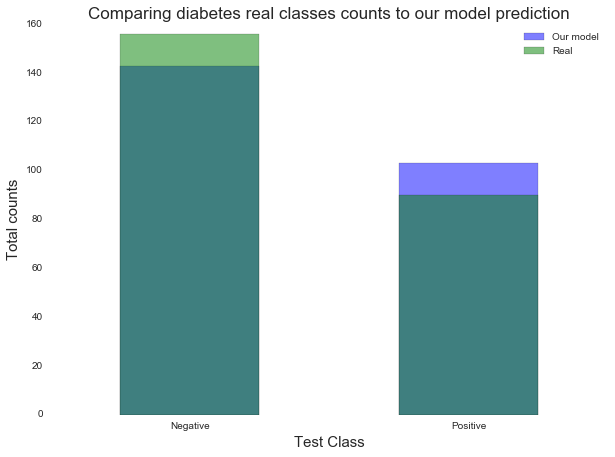

In [176]:
%matplotlib inline
def accuracy(test_set, predictions):
    correct = 0
    for x in range(len(test_set)):
        if test_set[x][-1] == predictions[x]:
            correct += 1
    accurate = (correct/float(len(test_set))) * 100.0
    
    return accurate

#train_set, test_set = split_data(dataset, 0.69)
#print test_set[:10]
#training = sort_data(train_set)

predictions = predict(sorted_data, test_set)
accuracy = accuracy(test_set, predictions)
print('Accuracy of our model reads: {0}').format(accuracy)
print '-'*45

#------------------------ Plotting:
p_samples = Series(predictions)
p_counts = p_samples.value_counts()
t_sample = [item[-1] for item in test_set]
t_samples = Series(t_sample[:len(predictions)])
t_counts = t_samples.value_counts()

f, ax = plt.subplots(1, figsize=(10,7))
bar_width = 0.5
ind = range(len(p_counts))
tick_pos = [i+(bar_width/2) for i in ind]

ax.bar(ind, p_counts, width=bar_width, label='Our model', alpha=0.5, color='blue')
ax.bar(ind, t_counts, width=bar_width, label='Real', alpha=0.5, color='green')

# Set the label and legends
ax.set_ylabel("Total counts", fontsize=15)
ax.set_xlabel("Test Class", fontsize=15)
ax.set_axis_bgcolor('white')

plt.legend(loc='upper right')
plt.xticks(tick_pos, ['Negative', 'Positive'])
plt.title('Comparing diabetes real classes counts to our model prediction', fontsize=17)
# Set a buffer around the edge
plt.xlim([min(tick_pos)-bar_width, max(tick_pos)+bar_width])
plt.show()

accuracy generated by scikit-learn: 74.9521988528%
accuracy generated by our model: 76.8292682927%
---------------------------------------------
scikit-learn model score:  0.558317399618
our model score:  0.528455284553
---------------------------------------------


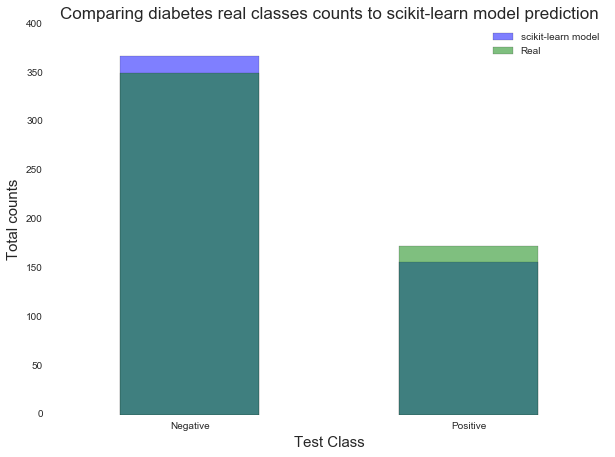

In [177]:
from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

features = [item[:-1] for item in dataset]
target = [item[-1] for item in dataset]
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size = 0.68, random_state = 10)  

#print len(features_train), len(features_test), len(target_train), len(target_test)

clf = GaussianNB()
clf.fit(features_train, target_train)
target_pred = clf.predict(features_test)
#print target_pred
sci_accuracy = accuracy_score(target_test, target_pred, normalize = True)
print 'accuracy generated by scikit-learn: {}%'.format(sci_accuracy * 100)

# predictions = predict(training, test_set)
# accuracy = accuracy(test_set, predictions)
print('accuracy generated by our model: {0}%').format(accuracy)

real = []
for i in test_set:
    for j in range(len(i)):
        x = i[-1]
        real.append(x)
print '-'*45 
print 'scikit-learn model score: ', accuracy_score(real[:len(target_pred)], target_pred)
print 'our model score: ', accuracy_score(real[:len(predictions)], predictions)
print '-'*45

#------------------------ Plotting:
p_samples = Series(target_pred)
p_counts = p_samples.value_counts()
#t_sample = [item[-1] for item in target]
t_samples = Series(target[-len(target_pred):])
t_counts = t_samples.value_counts()

# print len(p_samples), len(target[-len(target_pred):])
# print target

f, ax = plt.subplots(1, figsize=(10,7))
bar_width = 0.5
tick_pos = [i+(bar_width/2) for i in ind]

ax.bar(ind, p_counts, width=bar_width, label='scikit-learn model', alpha=0.5, color='blue')
ax.bar(ind, t_counts, width=bar_width, label='Real', alpha=0.5, color='green')

# Set the label and legends
ax.set_ylabel("Total counts", fontsize=15)
ax.set_xlabel("Test Class", fontsize=15)
ax.set_axis_bgcolor('white')

plt.legend(loc='upper right')
plt.xticks(tick_pos, ['Negative', 'Positive'])
plt.title('Comparing diabetes real classes counts to scikit-learn model prediction', fontsize=17)
# Set a buffer around the edge
plt.xlim([min(tick_pos)-bar_width, max(tick_pos)+bar_width])
plt.show()